## Dataset: Maternal Health Risk

### Licence of use

- That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/863/maternal+health+risk

- licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/


## About the dataset

- The Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.

###  Attributes Description:

- Age - Age in years when a woman is pregnant
- SystolicBP - Upper value of Blood Pressure in mmHg
- DiastolicBP - Lower value of Blood Pressure in mmHg
- BS - Blood glucose levels is in terms of a molar concentration, mmol/L
- BodyTemp - Body temperature in Fahrenheit
- HeartRate - Resting heart rate in beats per minute
- RiskLevel - Predicted Risk Intensity Level during pregnancy ['high risk', 'mid risk', 'low risk']

In [57]:
sc

<SparkContext master=local[*] appName=PySparkShell>

# 2. Data Understanding Phase

### Practical Big Data (PySparkSQL) - Part 1

In [58]:
# Load the libraries
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

In [59]:
# Due the different version of python can be found and each machine or libriries 
# Avoid warnigs
import warnings
warnings.filterwarnings("ignore")

In [60]:
#Import PySparkSQL
import pyspark
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("Análise de Dados de Saúde Materna") \
    .getOrCreate()

In [61]:
# Path to dataset
csv_file = "/user/user1/Maternal_Health_Risk.csv"

# Read and create a temporary view
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load(csv_file)
df.createOrReplaceTempView("rawdata")

In [6]:
# Visualise inferred schema
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)



In [7]:
# Execute an SQL query to select the first 10 rows from the temporary view
data = spark.sql("SELECT * FROM rawdata LIMIT 10")

# Directly display the query results
data.show()

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
| 23|       140|         80|7.01|    98.0|       70|high risk|
| 23|       130|         70|7.01|    98.0|       78| mid risk|
| 35|        85|         60|11.0|   102.0|       86|high risk|
| 32|       120|         90| 6.9|    98.0|       70| mid risk|
| 42|       130|         80|18.0|    98.0|       70|high risk|
+---+----------+-----------+----+--------+---------+---------+



In [63]:
# Count rows
num_rows = spark.sql("SELECT COUNT(*) as TotalRows FROM rawdata").show()

# Count columns using the PySpark DataFrame (not directly SQL)
num_columns = len(df.columns)
print(f"Number of Columns: {num_columns}")

+---------+
|TotalRows|
+---------+
|     1014|
+---------+

Number of Columns: 7


### Missing values

In [64]:
from pyspark.sql.functions import col, sum as _sum, when

# Listing the number of missing values per column
df.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+---+----------+-----------+---+--------+---------+---------+
|Age|SystolicBP|DiastolicBP| BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+---+--------+---------+---------+
|  0|         0|          0|  0|       0|        0|        0|
+---+----------+-----------+---+--------+---------+---------+



In [66]:
# Collecting data for visualization
risk_level_distribution = spark.sql("SELECT RiskLevel, COUNT(*) as Count FROM rawdata GROUP BY RiskLevel").toPandas()

# Check the collected data
print(risk_level_distribution)

   RiskLevel  Count
0   low risk    406
1   mid risk    336
2  high risk    272


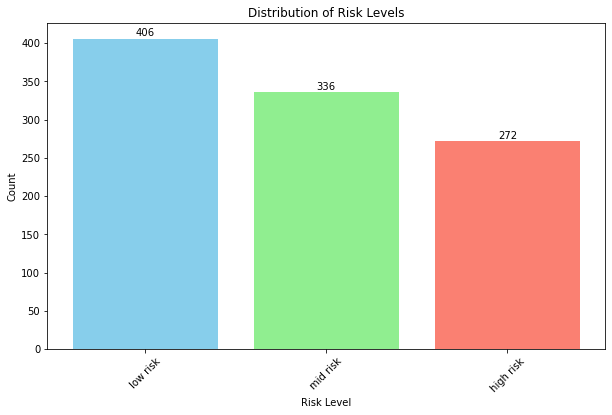

In [69]:
import matplotlib.pyplot as plt

# Plotting the distribution of Risk Levels with counts above bars
plt.figure(figsize=(10, 6))
bars = plt.bar(risk_level_distribution['RiskLevel'], risk_level_distribution['Count'], color=['skyblue', 'lightgreen', 'salmon'])

# Adding counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Comparative bar chart for average Systolic and Diastolic blood pressure, by Risk Level level.

In [73]:
# Determining the associations between the average systolic and diastolic blood pressures (SystolicBP and DiastolicBP, respectively) and the RiskLevel.
pressure_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(SystolicBP) AS AvgSystolicBP, 
    AVG(DiastolicBP) AS AvgDiastolicBP 
FROM rawdata 
GROUP BY RiskLevel
""").toPandas()

- The purpose of the query is to evaluate the data with an emphasis on determining the associations between the average systolic and diastolic blood pressures SystolicBP and DiastolicBP, respectively and the RiskLevel.

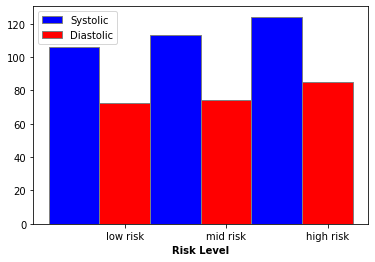

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Bar width
barWidth = 0.50

# Setting the position of the bars
r1 = np.arange(len(pressure_risk['RiskLevel']))
r2 = [x + barWidth for x in r1]

# Creating the bars
plt.bar(r1, pressure_risk['AvgSystolicBP'], color='blue', width=barWidth, edgecolor='grey', label='Systolic')
plt.bar(r2, pressure_risk['AvgDiastolicBP'], color='red', width=barWidth, edgecolor='grey', label='Diastolic')

# Adding labels to the bars
plt.xlabel('Risk Level', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(pressure_risk['RiskLevel']))], pressure_risk['RiskLevel'])

# Creating the legend and showing the plot
plt.legend()
plt.show()

Este código primeiro configura o ambiente de plotagem determinando a largura das barras e a posição delas no gráfico. Depois, plota duas séries de dados: uma para a pressão sistólica média e outra para a diastólica média, cada uma associada a um nível de risco diferente. A legenda e os rótulos dos eixos ajudam a tornar o gráfico mais legível.

Esse gráfico proporcionará uma visualização clara das diferenças nas médias de pressão sistólica e diastólica entre os diferentes níveis de risco. Se precisar de mais ajuda ou tiver outras perguntas, estou aqui!

In [16]:
age_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(Age) AS AvgAge 
FROM rawdata 
GROUP BY RiskLevel
ORDER BY CASE 
    WHEN RiskLevel = 'low risk' THEN 1
    WHEN RiskLevel = 'mid risk' THEN 2
    WHEN RiskLevel = 'high risk' THEN 3
    ELSE 4
END
""").toPandas()

- By analyzing how the average age varies between different risk levels, through this analysis it is possible to identify age-related patterns or trends that may be relevant to understanding risk.

### Average Age by Risk Level chart

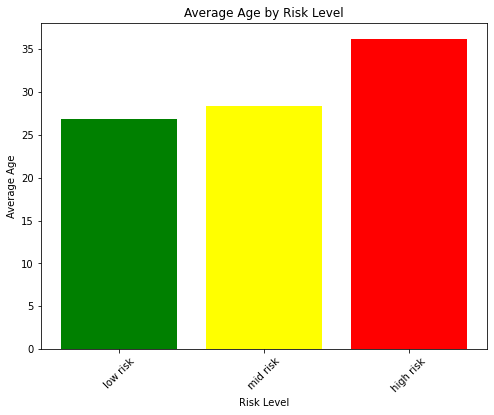

In [83]:
import matplotlib.pyplot as plt

# Adjusting color_mapping to match the exact strings from the SQL query
color_mapping = {
    'high risk': 'red',    # Matching 'high risk' to red
    'mid risk': 'yellow',  # Matching 'mid risk' to yellow
    'low risk': 'green'    # Matching 'low risk' to green
}

# Applying the color mapping to generate a list of colors for each bar
# This assumes age_risk['RiskLevel'] contains 'low risk', 'mid risk', 'high risk'
bar_colors = [color_mapping[risk_level] for risk_level in age_risk['RiskLevel']]

plt.figure(figsize=(8, 6))
plt.bar(age_risk['RiskLevel'], age_risk['AvgAge'], color=bar_colors)

# Adding titles and labels
plt.title('Average Age by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Average Age')
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability

# Displaying the chart
plt.show()

- This chart provides a clear visualization of how the average age varies between different risk levels. This can help identify whether there is an age trend associated with risk level.

# Modeling Phase

##  Neural Network For Binary Classification

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determine the number of input features
n_features = X_train_scaled.shape[1]

# Create a Sequential model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(n_features,)))
model.add(Dense(8, activation='relu'))
# If RiskLevel is binary, use 1 output neuron with sigmoid, otherwise adjust for multiclass
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' and adjust the number of neurons if it's multiclass

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust as necessary

- Import Libraries: Imports TensorFlow and specific modules for creating models (Sequential) and layers (Dense).

- Determine Number of Input Features: Sets n_features to the number of columns in X_train_scaled, excluding the target variable. This tells the model how many inputs each data point has.

- Create Sequential Model:

- A Sequential model is a linear stack of layers where each layer has exactly one input tensor and one output tensor.
- The Dense layer is a fully connected layer, meaning each neuron in the layer receives input from all neurons of the previous layer.
The first Dense layer specifies input_shape=(n_features,), which defines the shape of the input data.
relu (Rectified Linear Unit) is used as the activation function for hidden layers to introduce non-linearity, helping the network learn complex patterns.
Output Layer:

For binary classification (two classes), the output layer has 1 neuron and uses the sigmoid activation function, which outputs a probability (0 to 1) indicating class membership.
For multiclass classification, you would use the softmax activation function and adjust the number of neurons to match the number of classes.
Compile the Model:

The model is compiled with the adam optimizer, a popular choice that adjusts the learning rate dynamically.
binary_crossentropy is used as the loss function for binary classification, which is suitable for binary labels.
Metrics: accuracy is used to evaluate the performance of the model during training and testing.
Purpose
This code sets up a neural network for binary classification, preparing it for training with your dataset. The model learns to predict the binary RiskLevel based on input features. After training, it can classify new, unseen data points into one of the two categories based on the learned patterns.

This process is crucial for tasks where you need to categorize inputs into two groups, such as predicting whether a condition is present (risk) or not based on various indicators (features).

In [85]:
# Evaluating the model
history = model.fit(X_train_scaled, y_train, epochs=140, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.2801 - loss: 0.7380 - val_accuracy: 0.2761 - val_loss: 0.6974
Epoch 2/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3763 - loss: 0.6641 - val_accuracy: 0.3926 - val_loss: 0.6259
Epoch 3/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4805 - loss: 0.6103 - val_accuracy: 0.4356 - val_loss: 0.5581
Epoch 4/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4771 - loss: 0.5379 - val_accuracy: 0.4540 - val_loss: 0.4842
Epoch 5/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5449 - loss: 0.4840 - val_accuracy: 0.4601 - val_loss: 0.3993
Epoch 6/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5283 - loss: 0.4276 - val_accuracy: 0.4601 - val_loss: 0.3055
Epoch 7/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5232 - loss: 0.3548 - val_accuracy: 0.4601 - val_loss: 0.2054
Epoch 8/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5335 - loss: 0.2721 - val_accuracy: 0.4

Certainly! This line of code is typically used in the context of training a machine learning model with the Keras API in TensorFlow, a popular deep learning library. The code snippet you provided is executing the fit method on a model object, which trains the model on the provided dataset. Here's a breakdown of each component in that line:

model.fit(...): This is the method call that trains the model. The model variable is an instance of a neural network or any model built using Keras. The fit method adjusts the model's weights to minimize the loss function, improving the model's performance on the training data.

X_train_scaled: This represents the input features for training the model, which have been scaled. Scaling input features is a common practice in machine learning to help the model learn more effectively. It ensures that the feature values are within a similar range, often leading to better performance.

y_train: This is the target data for the training set, which the model will try to predict. The y_train data contains the known outputs associated with each input vector in X_train_scaled.

epochs=140: An epoch is one complete pass through the entire training dataset. This parameter specifies that the model should be trained for 140 epochs, meaning the learning algorithm will work its way through the training dataset 140 times.

batch_size=32: This defines the number of samples that will be propagated through the network before the model's internal parameters are updated. In this case, the model weights are updated after every 32 samples are processed, which is a balance between the efficiency of batch processing and the fine-grained update approach of stochastic gradient descent.

validation_split=0.2: This parameter indicates that 20% of the training data should be held back and not used for training the model. Instead, this subset is used as a validation dataset to evaluate the model's performance after each epoch. This helps in monitoring the model's generalization ability to new, unseen data and in preventing overfitting.

verbose=1: This is a verbosity mode flag. Setting verbose=1 means that progress bars and one line per epoch will be displayed during the training process. It's a way to get real-time feedback on the training process, including the loss and any other metrics specified in the model compilation.

In summary, this code trains a neural network (or any model created with Keras) on the scaled training data (X_train_scaled, y_train), for 140 iterations over the entire dataset, updating the model weights after every 32 samples, while also evaluating model performance on a validation set that comprises 20% of the training data.

In [86]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test set accuracy: {accuracy:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5199 - loss: -608.2734 
Test set accuracy: 0.5074


Explanation
Model Evaluation: The model.evaluate() function tests the model on a separate dataset that it hasn't seen before, known as the test set (X_test_scaled, y_test). This function returns the loss value & metrics values for the model in test mode. In this case, since the model was compiled with accuracy as a metric, it returns both the loss (loss) and accuracy (accuracy).

Parameters:

X_test_scaled: The input features of the test set, which have been scaled in the same way as the training set features to ensure consistency in data representation.
y_test: The true labels of the test set, used to evaluate the model's predictions.
Printing Accuracy: The accuracy metric, which indicates the proportion of correct predictions out of all predictions made, is printed out formatted to four decimal places. Accuracy is a common metric for classification tasks and provides a quick sense of how well the model is performing. An accuracy of 1.0 means the model made correct predictions for every sample in the test set, while an accuracy closer to 0.0 means the model did not perform well.

This step is crucial for understanding the model's generalization capability, i.e., how well it performs on new, unseen data. High accuracy on the test set suggests that the model has learned the underlying patterns in the data rather than memorizing the training set, while low accuracy might indicate overfitting to the training data or underfitting, where the model is too simple to capture the data's complexity.

- Training Phase Output (Epoch Feedback)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step: This portion indicates the progress of the last batch of the training or evaluation process. Specifically:

7/7 means that all 7 batches have been processed. The first number changes as each batch is processed until it matches the total number of batches, which is the second number.
0s indicates the total time taken to process these batches was less than one second.
5ms/step suggests that, on average, each batch took 5 milliseconds to process.
accuracy: 0.5199: This is the accuracy of the model on the training set (or possibly the validation set, if this is during training with validation_split specified). Accuracy measures the proportion of correctly predicted instances out of all predictions made. Here, the model's accuracy is approximately 52%, indicating that about half of the model's predictions match the actual data labels.

loss: -608.2734: The loss function value quantifies how well the model's predictions match the actual labels, with lower values generally indicating better performance. However, a negative loss value, as shown here, is unusual for most loss functions and might indicate an issue with how the loss is calculated or with the model's configuration.

Test Set Evaluation Output
Test set accuracy: 0.5074: This value represents the model's accuracy evaluated on a separate test dataset that was not used during training. An accuracy of approximately 50.74% on the test set suggests that the model performs similarly on both unseen data and the training/validation data, predicting correctly a little over half of the time. This level of accuracy, similar to the training accuracy, indicates consistency but also suggests the model might not be highly effective for its intended task, depending on the complexity of the problem and the baseline accuracy (e.g., what accuracy a naive model might achieve).
Interpretation
Given the context:

An accuracy around 50% might be adequate for tasks akin to flipping a coin (binary outcomes with equal probability), but it's generally low for most machine learning tasks, suggesting the model might not have learned meaningful patterns from the data.
A negative loss value is unusual and might hint at an incorrect implementation of the loss function or an issue with the model setup. It's crucial to review the chosen loss function and ensure it aligns with the goals of the model and the nature of the problem being solved.
In summary, while the model demonstrates a consistent ability to predict correctly about half of the time across both training and test sets, the performance is not particularly high, and the negative loss value indicates a potential issue needing investigation.

In [92]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data

In [94]:
# making a prediction
new_data = np.array([[42, 140, 85, 13, 98, 75]])  # Replace with actual values
new_data_scaled = scaler.transform(new_data)  # This should work if 'scaler' is defined and fitted correctly
prediction = model.predict(new_data_scaled)
print(f'Prediction: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction: [[1.1180724e-16]]


- Explanation
This block of code demonstrates how to make a prediction using the trained neural network model for a new, unseen piece of data.

Prepare New Data: new_data is an np.array that contains a new data point. Each number in the array represents a feature's value. In this context, the features could represent different measurements or characteristics relevant to the model (e.g., age, systolic blood pressure, diastolic blood pressure, blood sugar, body temperature, heart rate). The specific values here (45, 150, 85, 13, 98, 75) are placeholders and should be replaced with actual values of the features for which you want to make a prediction.

Normalize New Data: The new data is then normalized using the scaler that was fitted on the training data. This step is crucial because the model expects data in the same format it was trained on, including the same scale. Normalization (or scaling) ensures that the input features have the same scale as the training data, which helps the model make accurate predictions.

Make a Prediction: The normalized new data is passed to the model.predict() method, which returns the model's prediction for the data. Since this is a classification model, the output will be the model's confidence levels for the different classes it was trained to predict.

Print Prediction: Finally, the prediction made by the model is printed. The output format will depend on the model's final layer and activation function. For binary classification problems using a sigmoid activation function in the output layer, this will typically be a probability score between 0 and 1, indicating the likelihood of the sample belonging to the positive class.

This example is essential for applying the model to real-world data, allowing you to understand how the model interprets and predicts based on new inputs.








In [39]:
pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 491.2 kB/s eta 0:00:00 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Tuning hyperparameter

In [87]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units_hidden', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Adjusting the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

This code snippet is for defining a function that builds a neural network model with customizable hyperparameters, intended for use with a hyperparameter tuning process. The build_model function takes a hp argument, which allows specifying hyperparameter ranges for the model's architecture and compilation settings, such as the number of units in the layers and the learning rate for the Adam optimizer. The model is compiled with binary crossentropy loss, making it suitable for binary classification tasks, and uses accuracy as a metric to evaluate performance.

In [95]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Maximum number of hyperparameter combinations to test
    executions_per_trial=2,  # Number of models to train and evaluate for each trial
    directory='tuner_results',
    project_name='keras_tuner_demo'
)

Reloading Tuner from tuner_results/keras_tuner_demo/tuner0.json


- RandomSearch tuner from Keras Tuner, setting up a hyperparameter tuning session for the model defined by the build model function. The tuner aims to optimize the validation accuracy  of the models it tests. It will experiment with up to 10 different hyperparameter combinations, training and evaluating 2 models for each trial to average out the performance metrics. The results of the tuning process, including the performance of each trial and the best hyperparameter settings found, will be stored in the tuner results directory under a project named keras tuner demo.


In [47]:
tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=1)

tuner.search(...): This method initiates the searching (tuning) process for the best hyperparameters for your model. The tuner object here has been previously set up with specific configurations such as the model-building function, the number of trials, and the objective metric to optimize.

X_train_scaled: This is the scaled training data that you're passing to the tuner. Scaling is a preprocessing step that is critical for many machine learning algorithms to perform well, especially neural networks. It involves transforming numerical features to have a certain range, such as between 0 and 1, to help the algorithm converge more quickly.

y_train: These are the target values (labels) for the training data. In the context of supervised learning, the model learns to predict these values from the X_train_scaled data.

epochs=20: This parameter specifies the number of times the learning algorithm will work through the entire training dataset. An epoch is one forward pass and one backward pass of all the training examples. In this case, the tuner will train each model configuration it tests for 20 epochs.

validation_split=0.2: This indicates that 20% of the training data should be set aside and not used for training the model. Instead, this data will be used to evaluate the model's performance. This helps in monitoring how well the model is generalizing to unseen data and can aid in preventing overfitting.

verbose=1: This is a verbosity mode setting. Setting verbose=1 will display detailed progress logs of the training process, including the loss and accuracy for each epoch. It provides a way to visually monitor the model's training progress.

In summary, this line instructs the tuner to start the hyperparameter tuning process. It will train and evaluate models using different combinations of hyperparameters specified in your build_model function, using the provided training data and settings. The process aims to find the set of hyperparameters that results in the model achieving the best performance according to the objective, in this case, validation accuracy (val_accuracy).

#### Retrieving and evaluate the best model found by the hyperparameter tuning process using Keras Tuner

In [98]:
# Best hyperparameter
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Evaluating the best model
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test set accuracy of the best model: {accuracy:.4f}')

print("Best hyperparameters:", best_hyperparameters.values)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5408 - loss: -95933.4375  
Test set accuracy of the best model: 0.5320
Best hyperparameters: {'units_input': 64, 'units_hidden': 448, 'learning_rate': 0.01}


Evaluation Metrics
accuracy: 0.5408: This is the accuracy of the best model on the validation set during the final epoch of training, indicating that the model correctly predicts 54.08% of the validation set. While better than random guessing in binary classification, this accuracy might still be considered low for many practical applications, depending on the specific problem and the baseline accuracy.

loss: -95933.4375: The negative loss value is highly unusual in the context of most problems, including binary classification with a binary crossentropy loss function. Typically, loss values are positive, and a negative value could indicate an issue with the loss function calculation, model configuration, or data. It warrants a thorough investigation.

Test Set Performance
Test set accuracy of the best model: 0.5320: The best model achieves an accuracy of 53.20% on the test set. This performance is close to its validation accuracy, indicating consistency in how the model generalizes to unseen data. However, the effectiveness of the model in practical terms may be limited due to the relatively low accuracy rate.
Best Hyperparameters
{'units_input': 64, 'units_hidden': 448, 'learning_rate': 0.01}: These are the hyperparameters of the best-performing model found by the tuner.
units_input: 64: The first (input) layer of the model consists of 64 units (neurons). This parameter controls the dimensionality of the first hidden layer's output space.
units_hidden: 448: The second hidden layer has 448 units. This is a relatively large number, suggesting that the model might be trying to capture complex patterns in the data.
learning_rate: 0.01: The learning rate for the Adam optimizer is set to 0.01. This is a crucial hyperparameter that controls the size of the steps the optimizer takes during the gradient descent process. A learning rate of 0.01 is relatively standard, balancing the speed of convergence with the risk of overshooting the minimum of the loss function.
Overall Implications
The results suggest that while the hyperparameter tuning process identified a specific model configuration as the best, the overall performance on the validation and test sets remains modest. The accuracy levels achieved suggest the model has limited predictive power, which might be insufficient for many applications. Moreover, the negative loss value indicates a potential issue that needs addressing.

It's advisable to review the model configuration, the data preprocessing steps, and the loss function implementation. Additionally, experimenting with different model architectures, loss functions, or even reevaluating the problem formulation and the data could provide pathways to improved performance.


### LTM Feedforward RNA

In [102]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Index the label if it's categorical
indexer = StringIndexer(inputCol="RiskLevel", outputCol="label")
df = indexer.fit(df).transform(df)

# Assemble features into a single feature vector
assembler = VectorAssembler(inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"], outputCol="features")
data = assembler.transform(df)

# Splitting the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3])

In [103]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Defining the neural network architecture
# The number of nodes in the input layer must match the number of features, and the number of nodes in the output layer must match the number of classes.
# In this example, we'll assume 3 classes (risks) and 6 features.
layers = [6, 5, 4, 3]

# Creating the classifier
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100)

-This code snippet is for setting up a Multilayer Perceptron (MLP) Classifier in PySpark, which is a type of neural network used for classification tasks. Here's what each part does in English:

Importing the MLP Classifier: The first line imports the MultilayerPerceptronClassifier class from Spark's machine learning library (MLlib). This class is used to create and train the MLP model.

Defining the Network Architecture: The layers array defines the architecture of the neural network. The number of nodes (neurons) in the input layer is 6, matching the number of features in the dataset. The network includes two hidden layers with 5 and 4 nodes, respectively, and the output layer has 3 nodes, corresponding to the 3 classes (risk levels). The structure of a network is crucial as it can significantly influence the model's performance.

Creating the Classifier: An instance of the MultilayerPerceptronClassifier is created with the specified layers. Additionally:

blockSize=128 specifies the size of blocks to be used for stacking input data in matrices to speed up the computation. Increasing the block size can utilize the computational power more efficiently at the cost of higher memory consumption.
seed=1234 is used to initialize the random number generator, ensuring that the results of the model training are reproducible.
maxIter=100 sets the maximum number of iterations (epochs) over the dataset for which the algorithm will run. If the algorithm converges (i.e., improvements become negligibly small) before reaching this limit, the training will stop early.
This setup is part of the process for preparing to train a neural network model on a dataset with 6 features to predict one of 3 possible risk levels. The use of an MLP in Spark allows for scalable and distributed computing over large datasets.


In [105]:
# Training the model
model = mlp.fit(train_data)

This line of code initiates the training process of the Multilayer Perceptron (MLP) classifier on the train_data. During training, the MLP will learn to classify input data into the predefined classes by adjusting its weights based on the input features and corresponding labels in the training dataset. This process iterates over the specified number of epochs or until convergence, as defined in the MLP configuration.


In [106]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Making predictions on the test set
predictions = model.transform(test_data)

# Evaluating accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5225806451612903


In [107]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.functions import col

# Making sure the 'label' column does not cause conflict
if "label" in df.columns:
    df = df.drop("label")

# Indexing categorical labels with a new column name to avoid conflicts
indexer = StringIndexer(inputCol="RiskLevel", outputCol="indexedLabel").fit(df)
df_indexed = indexer.transform(df)

# Assembling the features
assembler = VectorAssembler(
    inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"],
    outputCol="features")
df_assembled = assembler.transform(df_indexed)

# Normalizing the features (optional but recommended)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

# Splitting the data
(train_data, test_data) = df_scaled.randomSplit([0.8, 0.2])

This code block is part of a data preprocessing routine for a machine learning pipeline using PySpark's MLlib. Let's translate it into English and then explain its purpose and function:

Explanation
Avoiding Column Conflict: First, the code checks if a column named label already exists in the DataFrame df and drops it if found. This is to avoid conflicts with many machine learning algorithms that expect a column named label to be the target variable.

Indexing Categorical Labels: StringIndexer is used to convert the categorical labels in the RiskLevel column into numerical indices. This process is necessary because most machine learning models work with numerical data. The new indices are stored in a column named indexedLabel.

Assembling Features: VectorAssembler combines multiple columns (in this case, various features like Age, SystolicBP, etc.) into a single vector column named features. This step is required because Spark ML algorithms expect input data to be in this format.

Normalizing Features: StandardScaler standardizes the features by scaling them to have a mean of 0 and a standard deviation of 1. This step, while optional, is often recommended as it can improve the performance of many machine learning algorithms. The scaled features are stored in a new column named scaledFeatures.

Splitting the Data: Finally, the processed DataFrame is randomly split into training and test datasets, with 80% of the data going to the training set and the remaining 20% to the test set. This is a common practice in machine learning to evaluate the model's performance on unseen data.

Purpose
The entire process prepares the data for training a machine learning model by ensuring that the data is in the correct format, categorical labels are appropriately indexed, features are standardized, and the dataset is divided into training and testing sets. This preparation is crucial for the success of many machine learning tasks, including classification and regression.

- building, training, and evaluating a Multilayer Perceptron (MLP) classifier using PySpark's MLlib for a classification task

In [108]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Defining the network architecture: number of nodes in the input layer equals the number of features; adjust as necessary
layers = [6, 5, 4, 3]  # Example: 6 input features, two hidden layers (5 and 4 neurons), 3 outputs

mlp = MultilayerPerceptronClassifier(
    layers=layers,
    blockSize=128,
    seed=1234,
    maxIter=100,
    featuresCol="scaledFeatures",
    labelCol="indexedLabel")  # Adjust to use the 'indexedLabel' column

# Training the model
model = mlp.fit(train_data)

# Model evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5751


Neste exemplo, build_model é uma função que constrói um modelo Keras. Ela usa o objeto hp (de hiperparâmetros) do keras-tuner para explorar diferentes valores de unidades na camada oculta, taxas de aprendizado e otimizadores. O keras-tuner então busca no espaço de hiperparâmetros fornecido para encontrar a melhor combinação de acordo com a acurácia de validação.